# 10.5 Extended source simulations

So far, we have only dealt with simulations for single or multiple point sources. In the next step of the tutorial
we give an example for simulating data from extended sources.


In [9]:
import matplotlib.colors as colors
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import tempfile
import subprocess

from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import astropy_mpl_style
from datetime import datetime
from funcs import run_comm
from subprocess import check_call, STDOUT
from xspec import Xset, Plot, AllData, ModelManager, Spectrum, Model, AllModels, Fit

plt.style.use(astropy_mpl_style)

In [26]:
tmpDir = tempfile.mkdtemp()
os.environ["PFILES"] = tmpDir + ":" + os.environ["PFILES"]
os.environ["HEADASNOQUERY"] = ""
os.environ["HEADASPROMPT"] = "/dev/null/"
command = "bash -c 'source $HOME/workspace/Storage/sixte/sixte_volume/sixte_setup.sh && env'"
proc = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, text=True)

for line in proc.stdout:
    key, _, value = line.partition("=")
    os.environ[key] = value.strip()

proc.communicate()
home_dir = os.path.expanduser("~")
xmldir = f"{home_dir}/workspace/Storage/sixte/sixte_volume/sixtedata/instruments/athena-wfi/wfi_wo_filter" 
xml=f'{xmldir}/ld_wfi_ff_all_chips.xml'


## 10.5.1 Generating the SIMPUT file

The input for simulations of extended sources are source images which describe the spatial distribution of the
flux. Such images can be obtained, e.g., from earlier observations of a source or from models for the emission of
an extended source (e.g., in N-body simulations).
If using observational data, be aware that features caused by the instrument that made these images will also be
present in the simulated data. Such features will be, e.g., “spots” or photon noise in low signal to noise regions
of the image (these can often be compensated for by convolving the original image with a Gaussian filter, albeit
at a loss of resolution), effects of the PSF of the imaging instrument, or gaps such as those between the CCDs of
XMM-Newton. Typically, for the simulation not to be influenced by these effects you want to choose an image
that has a high signal to noise and that has a higher spatial resolution than that of the instrument for which the
simulation is performed. Note that the old adage “garbage in – garbage out” also applies to simulations. . .


Download Chandra images:

https://chandra.harvard.edu/photo/2014/etacar/fits/etaCar_xray_low.fits  (0.5-1.2 keV)  
https://chandra.harvard.edu/photo/2014/etacar/fits/etaCar_xray_med.fits  (1.2-2.0 keV)  
https://chandra.harvard.edu/photo/2014/etacar/fits/etaCar_xray_hi.fits   (2.0-7.0 keV)  

Here, we use a set of images obtained with Chandra. These images are already preprocessed, they are convolved with Gaussians to remove photon artifacts. For a large number of sources, images are available in several energy bands.
For the example here, we use data from the colliding wind binary η Car, published by Hamaguchi et al. (2014).
The Chandra web page contains images in three energy bands, 0.5–1.2 keV, 1.2–2.0 keV, and 2.0–7.0 keV.
In order to generate the SIMPUT file, we need to know the source position, the spectral shape, as well as the
source flux in each of these bands. The image we just downloaded is the average of all ACIS observations during
the X-ray minimum between 2003 and 2009. 

### The source position can be obtained from the image files

In [27]:
f = fits.open('etaCar_xray_hi.fits')
RAsrc = f[0].header['CRVAL1']
Decsrc = f[0].header['CRVAL2']
f.close()

# Use flux data from bibliography
flux_centralsrc_3_8 = 1E-11 # erg/cm2/s from Hamaguchi et al. 2014  -> assign it to the whole image
flux_diffemission_02_10 = 2.2E-12 # erg/cm2/s Seward et al. 2001

# Define bands and energt limits
E_minmax = {"high" : [2.,7.],
            "med"  : [1.2,2.],
            "low"  : [0.5,1.2]
           }
E_lowup = {"high" : [2.,10.],
           "med"  : [1.0,2.5],
           "low"  : [0.1,1.5]
          }

In [12]:
RAsrc, Decsrc

(161.267156643662, -59.684372315062)

###  Xspec file (simple powerlaw emission model with constant flux (Hamaguchi et al. 2014 does not give spectral parameters)

In [13]:
xcm = "constflux.xcm"

AllModels.clear()
AllData.clear()
mcmod = Model("power")
mcmod.powerlaw.PhoIndex = 1
mcmod.powerlaw.norm = 1

clobber = True
# If clobber is true and the file exists, it will be removed before creating a new one.
if os.path.exists(xcm):
    if clobber:
        os.remove(xcm)
    else:
        raise Exception(f"Xspec file ({xcm}) already exists: it will not be overwritten") 
Xset.save(xcm)


Model powerlaw<1> Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   powerlaw   PhoIndex            1.00000      +/-  0.0          
   2    1   powerlaw   norm                1.00000      +/-  0.0          
________________________________________________________________________



### Create simput file with `simputfile`

In [14]:
f = fits.open('etaCar_xray_hi.fits')
RA = f[0].header['CRVAL1']
Dec = f[0].header['CRVAL2']
f.close()

sim_file_high = 'etaCar_high.fits'
comm = (f'simputfile Simput={sim_file_high} RA={RA} Dec={Dec} srcFlux={flux_centralsrc_3_8} ' + 
        f'Emin=3. Emax=8. Elow=2. Eup=10. XSPECFile={xcm} ImageFile=etaCar_xray_hi.fits clobber=yes')
#print(comm)
run_comm(comm, 'Creating simput file for eta car')

Creating simput file for eta car
simputfile Simput=etaCar_high.fits RA=161.267156643662 Dec=-59.684372315062 srcFlux=1e-11 Emin=3. Emax=8. Elow=2. Eup=10. XSPECFile=constflux.xcm ImageFile=etaCar_xray_hi.fits clobber=yes
finished successfully!


		XSPEC version: 12.14.1
	Build Date/Time: Thu Aug 22 22:23:14 2024


!XSPEC12>statistic chi
Default fit statistic is set to: Chi-Squared
   This will apply to all current and newly loaded spectra.

!XSPEC12>method leven 10 0.01

!XSPEC12>abund angr
 Solar Abundance Vector set to angr:  Anders E. & Grevesse N. Geochimica et Cosmochimica Acta 53, 197 (1989)

!XSPEC12>xsect vern
 Cross Section Table set to vern:  Verner, Ferland, Korista, and Yakovlev 1996

!XSPEC12>cosmo 70 0 0.73

!XSPEC12>xset delta 0.01
Parameter delta values for fits will now be 0.01 * parValue

!XSPEC12>systematic 0

 The default systematic error for models is set to 0


!XSPEC12>model  powerlaw  ;                1       0.01         -3         -2          9         10  ;  

## 10.5.1 Simulating the observation

### Running simulation with `sixtesim`

In [15]:
prefix = "high_"
RApoint = 161.56
DECpoint = -59.52
comm = (f'sixtesim XMLFile={xml} RA={RApoint} Dec={DECpoint} ' +
        f'Prefix={prefix} Simput={sim_file_high} EvtFile=evt.fits Exposure=1000 clobber=yes')
#print(comm)
run_comm(comm,'Creating simput file for eta car')

Creating simput file for eta car
sixtesim XMLFile=/home/idies/workspace/Storage/sixte/sixte_volume/sixtedata/instruments/athena-wfi/wfi_wo_filter/ld_wfi_ff_all_chips.xml RA=161.56 Dec=-59.52 Prefix=high_ Simput=etaCar_high.fits EvtFile=evt.fits Exposure=1000 clobber=yes
initialize ...
Seed = 1751238221
try to load all spectra ('etaCar_high.fits[SPECTRUM,1]') into cache ...

start simulation ...

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|

*** Warning in convSimputMIdpSpecWithARF: the spectrum 'etaCar_high.fits[SPECTRUM,1]' does not cover the full energy range of the ARF! ***
***************************************************


start event pattern analysis ...
start sky projection ...
start Pha2Pi correction ...
run pha2pi correction on event file ... 
start event pattern analysis ...
start sky projection ...
start Pha2Pi correction ...
run pha2pi correction on event file ... 
start event pattern analysis ...
start sky pro

### Merging chips with `ftmerge`

In [16]:
evt_final_high = 'etaCar_high_chip_merged.fits'

comm = (f'ftmerge {prefix}chip0_evt.fits,{prefix}chip1_evt.fits,{prefix}chip2_evt.fits,{prefix}chip3_evt.fits ' + 
        f'{evt_final_high} clobber=yes')
run_comm(comm, 'Merging 4 event files')

Merging 4 event files
ftmerge high_chip0_evt.fits,high_chip1_evt.fits,high_chip2_evt.fits,high_chip3_evt.fits etaCar_high_chip_merged.fits clobber=yes


### Create the image of the merged evt file with `imgev` 

In [17]:
img_final_high = 'etaCar_high_merged_img.fits'
comm = (f'imgev EvtFile={evt_final_high} Image={img_final_high} CoordinateSystem=0 Projection=TAN NAXIS1=1063 ' +
        f'NAXIS2=1063 CUNIT1=deg CUNIT2=deg CRVAL1={RApoint} CRVAL2={DECpoint} CRPIX1=532 CRPIX2=532 ' + 
        f'CDELT1=-6.207043e-04 CDELT2=6.207043e-04 history=true clobber=yes')
#print(comm)
run_comm(comm, "Creating image from merged evt file")

Creating image from merged evt file
imgev EvtFile=etaCar_high_chip_merged.fits Image=etaCar_high_merged_img.fits CoordinateSystem=0 Projection=TAN NAXIS1=1063 NAXIS2=1063 CUNIT1=deg CUNIT2=deg CRVAL1=161.56 CRVAL2=-59.52 CRPIX1=532 CRPIX2=532 CDELT1=-6.207043e-04 CDELT2=6.207043e-04 history=true clobber=yes
initialize ...
open event file 'etaCar_high_chip_merged.fits' ...
finished successfully!



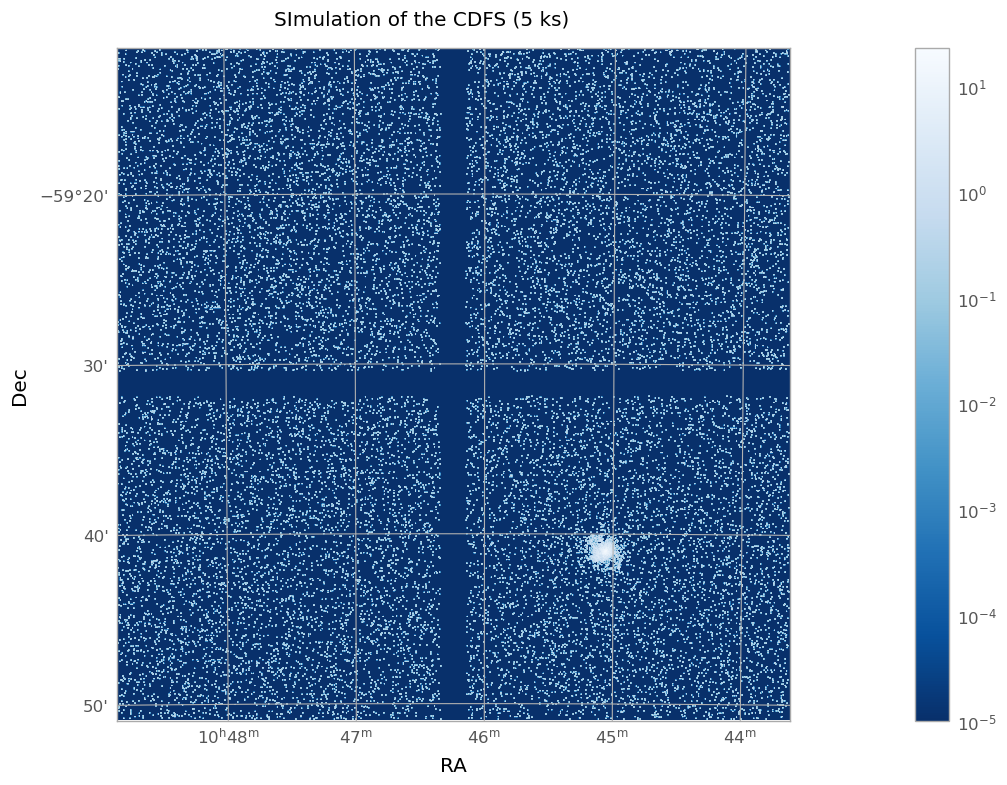

In [18]:
image_data = fits.getdata(img_final_high, ext=0)
hdu = fits.open(img_final_high)[0]
wcs = WCS(hdu.header)

fig = plt.figure(figsize=(14,8))
fig.suptitle("SImulation of the CDFS (5 ks)")
#cmap = plt.cm.winter
cmap = plt.cm.Blues_r

#plot image
ax = fig.add_subplot(1, 1, 1, projection=wcs)
im = ax.imshow(image_data, cmap=cmap, norm=colors.LogNorm(vmin=1e-5, vmax=np.max(image_data), clip=True), origin="lower")
ax.set_xlabel("RA")
ax.set_ylabel("Dec")
fig.colorbar(im,ax=ax, pad=0.1)
plt.tight_layout();

### <span style="color:blue">$\textbf{Exercise}$</span>:
#### Generate a spectrum of chip0 and verify that indeed only photons between 2 and 10 keV are generated. Where do the photons detected below 2 keV come from?

In [19]:
# Create spectrum
spec_file = f'{prefix}chip0_spec.pha'
comm = (f"makespec EvtFile={prefix}chip0_evt.fits Spectrum={spec_file} clobber=yes RSPPath={xmldir}")
#print(comm)
run_comm(comm,'Generating spectrum for chip0')

Generating spectrum for chip0
makespec EvtFile=high_chip0_evt.fits Spectrum=high_chip0_spec.pha clobber=yes RSPPath=/home/idies/workspace/Storage/sixte/sixte_volume/sixtedata/instruments/athena-wfi/wfi_wo_filter
SIXTE version 3.0.7
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
Seed = 1910086416
calculate spectrum ...
store spectrum ...


In [20]:
# shorten ARF and RMF paths
f = fits.open(spec_file)
rmf = f[1].header['RESPFILE']
arf = f[1].header['ANCRFILE']
f.close()

## create symlinks if not already done (uncomment)
#run_comm('ln -s {}'.format(rmf), 'Linking to working directory')
#run_comm('ln -s {}'.format(arf), 'Linking to working directory')

# strip path in keywords to avoid very long values and update header
#rmf = os.path.basename(rmf)
#arf = os.path.basename(arf)
#f = fits.open(spec_file, 'update')
#f[1].header['RESPFILE'] = rmf
#f[1].header['ANCRFILE'] = arf
#f.close()


1 spectrum  in use
 
Spectral Data File: high_chip0_spec.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  8.104e+00 +/- 9.002e-02
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-1498
  Telescope: Athena Instrument: WFI  Channel Type: PI
  Exposure Time: 1000 sec
 Using fit statistic: chi
 Using Response (RMF) File            /home/idies/workspace/Storage/sixte/sixte_volume/sixtedata/instruments/athena-wfi/wfi_wo_filter/athena_wfi_pirmf_v20230609.rmf for Source 1
 Using Auxiliary Response (ARF) File  /home/idies/workspace/Storage/sixte/sixte_volume/sixtedata/instruments/athena-wfi/wfi_wo_filter/athena_wfi_sixte_13rows_wo_filter_LDA_v20240209.arf



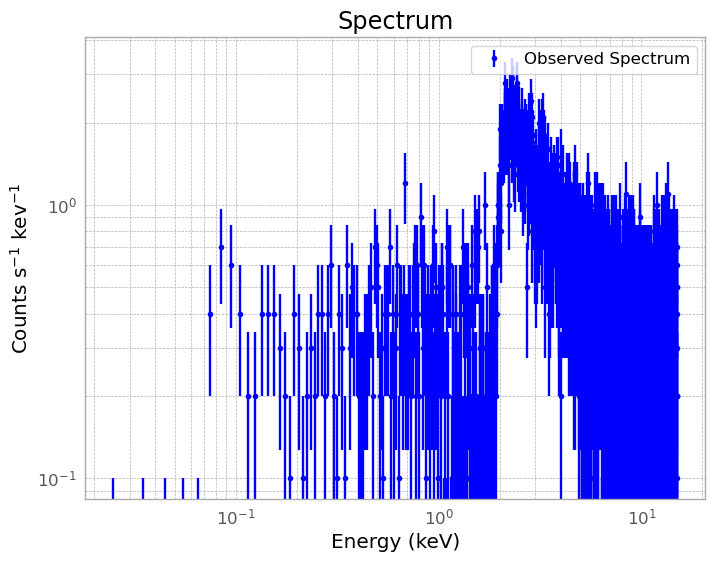

In [21]:
# Plot spectrum
Plot.device = '/null'
AllData.clear()
AllModels.clear()

Plot.xAxis="keV"
s1 = Spectrum(spec_file)
Plot("ldata")
Plot.device = '/null'

energies = Plot.x()      
counts = Plot.y()            
errors = Plot.yErr()       
plt.errorbar(energies, counts, yerr=errors, fmt='o', label="Observed Spectrum", color='blue', markersize=3)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Energy (keV)")
plt.ylabel("Counts s$^{-1}$ kev$^{-1}$")
plt.title("Spectrum")
plt.legend()
plt.grid(True, which="both", linestyle="--", lw=0.5)
plt.show()

### <span style="color:blue">$\textbf{Exercise}$</span>:
#### Generate two more SIMPUT files using the *medium* and *low* band, merge them with `simputmerge`, and perform a new WFI simulation.


In [22]:
# simput file

for band in ['med','low']: 
    sim_file = f'etaCar_{band}.fits'
    img_file = f'etaCar_xray_{band}.fits'
    DeltaE = E_minmax[band][1] - E_minmax[band][0]
    flux = flux_centralsrc_3_8/5.*DeltaE 
    comm = (f'simputfile Simput={sim_file} RA={RA} Dec={Dec} srcFlux={flux} Emin={E_minmax[band][0]} Emax={E_minmax[band][1]} ' + 
            f'Elow={E_lowup[band][0]} Eup={E_lowup[band][1]} XSPECFile={xcm} ImageFile={img_file} clobber=yes')
    #print(comm)
    run_comm(comm, 'Creating simput file for eta car in band {band}')

Creating simput file for eta car in band {band}
simputfile Simput=etaCar_med.fits RA=161.267156643662 Dec=-59.684372315062 srcFlux=1.6e-12 Emin=1.2 Emax=2.0 Elow=1.0 Eup=2.5 XSPECFile=constflux.xcm ImageFile=etaCar_xray_med.fits clobber=yes
finished successfully!


		XSPEC version: 12.14.1
	Build Date/Time: Thu Aug 22 22:23:14 2024


!XSPEC12>statistic chi
Default fit statistic is set to: Chi-Squared
   This will apply to all current and newly loaded spectra.

!XSPEC12>method leven 10 0.01

!XSPEC12>abund angr
 Solar Abundance Vector set to angr:  Anders E. & Grevesse N. Geochimica et Cosmochimica Acta 53, 197 (1989)

!XSPEC12>xsect vern
 Cross Section Table set to vern:  Verner, Ferland, Korista, and Yakovlev 1996

!XSPEC12>cosmo 70 0 0.73

!XSPEC12>xset delta 0.01
Parameter delta values for fits will now be 0.01 * parValue

!XSPEC12>systematic 0

 The default systematic error for models is set to 0


!XSPEC12>model  powerlaw  ;                1       0.01         -3         -2       

### Merge high, med and low  SIMPUT files (high obtained in the cells above) with `simputmerge`

In [24]:
opt = "clobber=yes FetchExtensions=yes"
simput_file_allbands = 'etaCar_allbands.fits'

comm = (f"simputmerge {opt} Infile1=etaCar_low.fits Infile2=etaCar_med.fits Outfile=tmp.fits")
#print(comm)
run_comm(comm, "Merging simputfiles _low_ and _med_")

comm = (f"simputmerge {opt} Infile1=etaCar_high.fits Infile2=tmp.fits Outfile={simput_file_allbands}")
#print(comm)
run_comm(comm, "Merging simputfiles _low_, _med_ and _high")

Merging simputfiles _low_ and _med_
simputmerge clobber=yes FetchExtensions=yes Infile1=etaCar_low.fits Infile2=etaCar_med.fits Outfile=tmp.fits

merging simput files ...
100%

cleaning up ...
finished successfully!

Merging simputfiles _low_, _med_ and _high
simputmerge clobber=yes FetchExtensions=yes Infile1=etaCar_high.fits Infile2=tmp.fits Outfile=etaCar_allbands.fits

merging simput files ...
150%

cleaning up ...
finished successfully!



### Run the new simulation with `sixtesim` and merge the 4 chips with `ftmerge`

In [25]:
base = "etaCar_"
comm = (f'sixtesim XMLFile={xml} RA={RApoint} Dec={DECpoint} ' + 
        f'Prefix={base} Simput={simput_file_allbands} EvtFile=evt.fits Exposure=1000 clobber=yes')
#print(comm)
run_comm(comm, 'Running simulation for eta car all bands')

# mergin all chips
evt_final_merged = f'{base}allbands_merged_evt.fits'
comm = (f'ftmerge {base}chip0_evt.fits,{base}chip1_evt.fits,{base}chip2_evt.fits,{base}chip3_evt.fits ' + 
        f'{evt_final_merged} clobber=yes')
#print(comm)
run_comm(comm,'Merging 4 event files')


Running simulation for eta car all bands
sixtesim XMLFile=/home/idies/workspace/Storage/sixte/sixte_volume/sixtedata/instruments/athena-wfi/wfi_wo_filter/ld_wfi_ff_all_chips.xml RA=161.56 Dec=-59.52 Prefix=etaCar_ Simput=etaCar_allbands.fits EvtFile=evt.fits Exposure=1000 clobber=yes
initialize ...
Seed = 2010513472
try to load all spectra ('etaCar_allbands.fits[SPECTRUM,1]') into cache ...

start simulation ...

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|

*** Warning in convSimputMIdpSpecWithARF: the spectrum 'etaCar_allbands.fits[SPECTRUM,1][NAME=='spec_0000000001']' does not cover the full energy range of the ARF! ***

*** Warning in convSimputMIdpSpecWithARF: the spectrum 'etaCar_allbands.fits[SPECTRUM,1][NAME=='spec_0000000002']' does not cover the full energy range of the ARF! ***

*** Warning in convSimputMIdpSpecWithARF: the spectrum 'etaCar_allbands.fits[SPECTRUM,1][NAME=='spec_0000000003']' does not cover the ful

### <span style="color:blue">$\textbf{Exercise (harder)}$</span>:
#### Rather than describing the spectral shapes with constants, describe the overall spectral shape of $\eta$ Car and the Humunculus nebula using an apec model with a temperature of kT = 4 keV, absorbed by NH = 2 $\cdot$ 10$^{22}$ cm$^{−2}$. Use XSPEC to determine the relative fluxes for the three energy bands for which Chandra images are available. Then generate three SIMPUT files, fixing the hard band flux to $10^{−11}$ cgs and the two lower fluxes to values appropriate for the absorbed apec model. Do not forget to set Eup and Elow appropriately. Perform the simulation again

xspec file with apec model (https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/XSmodelApec.html) and phabs 
(https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node255.html)

#### Create the `xcm` file for each band

In [28]:
xcm = "etaCar_apec.xcm"

AllData.clear()
AllModels.clear()
mcmod = Model("apec * phabs")
mcmod.apec.kT = 4
mcmod.phabs.nH = 2

# Fluxes for the 3 bands
AllModels.calcFlux('2. 7.')
flux_high_nonorm = mcmod.flux[0]

AllModels.calcFlux('0.5 1.2')
flux_low_nonorm = mcmod.flux[0]

AllModels.calcFlux('1.2 2')
flux_med_nonorm = mcmod.flux[0]

flux = dict()
flux["high"] = 1E-11
flux["low"] = (flux_low_nonorm/flux_high_nonorm)*flux["high"]
flux["med"] = (flux_med_nonorm/flux_high_nonorm)*flux["high"]

clobber = True
# If clobber is true and the file exists, it will be removed before creating a new one.
if os.path.exists(xcm):
    if clobber:
        os.remove(xcm)
    else:
        raise Exception(f"Xspec file ({xcm}) already exists: it will not be overwritten") 
Xset.save(xcm)

Reading APEC data from 3.0.9


Model apec<1>*phabs<2> Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   apec       kT         keV      1.00000      +/-  0.0          
   2    1   apec       Abundanc            1.00000      frozen
   3    1   apec       Redshift            0.0          frozen
   4    1   apec       norm                1.00000      +/-  0.0          
   5    2   phabs      nH         10^22    1.00000      +/-  0.0          
________________________________________________________________________

 Model Flux   0.10888 photons (6.8031e-10 ergs/cm^2/s) range (2.0000 - 7.0000 keV)
 Model Flux 0.0019095 photons (3.3996e-12 ergs/cm^2/s) range (0.50000 - 1.2000 keV)
 Model Flux  0.023741 photons (6.3387e-11 ergs/cm^2/s) range (1.2000 - 2.0000 keV)


#### Create the SIMPUT files for each bands with `simputfile`

In [29]:
base = 'etaCar_apec_'
for band in ["low", "med", "high"]:
    sim_file = f"{base}{band}.fits"
    img_band = band
    if band == "high":
        img_band = "hi"
    comm = (f"simputfile Simput={sim_file} RA={RA} Dec={Dec} srcFlux={flux[band]} " + 
            f"Emin={E_minmax[band][0]} Emax={E_minmax[band][1]} Elow={E_lowup[band][0]} Eup={E_lowup[band][1]} " + 
            f"XSPECFile={xcm} ImageFile=etaCar_xray_{img_band}.fits clobber=yes")
    #print(comm)
    run_comm(comm, f"Creating simput file for apec model and band {band}")

Creating simput file for apec model and band low
simputfile Simput=etaCar_apec_low.fits RA=161.267156643662 Dec=-59.684372315062 srcFlux=4.9970929894500365e-14 Emin=0.5 Emax=1.2 Elow=0.1 Eup=1.5 XSPECFile=etaCar_apec.xcm ImageFile=etaCar_xray_low.fits clobber=yes
finished successfully!


		XSPEC version: 12.14.1
	Build Date/Time: Thu Aug 22 22:23:14 2024


!XSPEC12>statistic chi
Default fit statistic is set to: Chi-Squared
   This will apply to all current and newly loaded spectra.

!XSPEC12>method leven 10 0.01

!XSPEC12>abund angr
 Solar Abundance Vector set to angr:  Anders E. & Grevesse N. Geochimica et Cosmochimica Acta 53, 197 (1989)

!XSPEC12>xsect vern
 Cross Section Table set to vern:  Verner, Ferland, Korista, and Yakovlev 1996

!XSPEC12>cosmo 70 0 0.73

!XSPEC12>xset delta 0.01
Parameter delta values for fits will now be 0.01 * parValue

!XSPEC12>systematic 0

 The default systematic error for models is set to 0


!XSPEC12>model  apec*phabs  ;                4       0.01    

#### Merge the three SIMPUT files for each band with `simputmerge`

In [30]:
opt = "clobber=yes FetchExtensions=yes"
simput_file_apec_allbands = 'etaCar_apec_allbands.fits'
comm = (f"simputmerge {opt} Infile1=etaCar_apec_low.fits Infile2=etaCar_apec_med.fits Outfile=tmp.fits")
#print(comm)
run_comm(comm, "Merging simputfiles _low_ and _med_")
comm = (f"simputmerge {opt} Infile1=etaCar_apec_high.fits Infile2=tmp.fits Outfile={simput_file_apec_allbands}")
#print(comm)
run_comm(comm, "Merging simputfiles _low_ and _med_")

Merging simputfiles _low_ and _med_
simputmerge clobber=yes FetchExtensions=yes Infile1=etaCar_apec_low.fits Infile2=etaCar_apec_med.fits Outfile=tmp.fits

merging simput files ...
100%

cleaning up ...
finished successfully!

Merging simputfiles _low_ and _med_
simputmerge clobber=yes FetchExtensions=yes Infile1=etaCar_apec_high.fits Infile2=tmp.fits Outfile=etaCar_apec_allbands.fits

merging simput files ...
150%

cleaning up ...
finished successfully!



#### Run the new simulation eith `sixtesim` and merge the 4 chips

In [31]:
evt_final_merged = f'{base}allbands_merged_evt.fits'

comm = (f'sixtesim XMLFile={xml} RA={RApoint} Dec={DECpoint} ' + 
        f'Prefix={base} Simput={simput_file_apec_allbands} EvtFile=evt.fits Exposure=10000 clobber=yes')
#print(comm)
run_comm(comm,'Running simulation for eta car')
comm = (f'ftmerge {base}chip0_evt.fits,{base}chip1_evt.fits,{base}chip2_evt.fits,{base}chip3_evt.fits {evt_final_merged} clobber=yes')
#print(comm)
run_comm(comm,'Merging 4 event files')

Running simulation for eta car
sixtesim XMLFile=/home/idies/workspace/Storage/sixte/sixte_volume/sixtedata/instruments/athena-wfi/wfi_wo_filter/ld_wfi_ff_all_chips.xml RA=161.56 Dec=-59.52 Prefix=etaCar_apec_ Simput=etaCar_apec_allbands.fits EvtFile=evt.fits Exposure=10000 clobber=yes
initialize ...
Seed = 2437717943
try to load all spectra ('etaCar_apec_allbands.fits[SPECTRUM,1]') into cache ...

start simulation ...

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|

*** Warning in convSimputMIdpSpecWithARF: the spectrum 'etaCar_apec_allbands.fits[SPECTRUM,1][NAME=='spec_0000000001']' does not cover the full energy range of the ARF! ***

*** Warning in convSimputMIdpSpecWithARF: the spectrum 'etaCar_apec_allbands.fits[SPECTRUM,1][NAME=='spec_0000000002']' does not cover the full energy range of the ARF! ***

*** Warning in convSimputMIdpSpecWithARF: the spectrum 'etaCar_apec_allbands.fits[SPECTRUM,1][NAME=='spec_0000000003']' d

#### Create the spectrum with `makespec`

In [34]:
evt_file = f'{evt_final_merged}'
spec_file = 'spec_final_merged.pha'
comm = (f"makespec EvtFile={evt_file} Spectrum={spec_file} "+ # EventFilter='(RA>-59.56 && RA<-59.48) && (Dec>161.52 && Dec<161.6)'
        f"clobber=yes RSPPath={xmldir}")
#print(comm)
run_comm(comm,'Generating spectrum')
# rebin spectral data
binspec = "spec_final_merged_rebin.pha"
comm = (f"grppha infile={spec_file} outfile={binspec} clobber=yes comm='group min 20 & exit'")
run_comm(comm, "Rebinning spectrum")

Generating spectrum
makespec EvtFile=etaCar_apec_allbands_merged_evt.fits Spectrum=spec_final_merged.pha clobber=yes RSPPath=/home/idies/workspace/Storage/sixte/sixte_volume/sixtedata/instruments/athena-wfi/wfi_wo_filter
SIXTE version 3.0.7
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
Seed = 2771246800
calculate spectrum ...
store spectrum ...
Rebinning spectrum
grppha infile=spec_final_merged.pha outfile=spec_final_merged_rebin.pha clobber=yes comm='group min 20 & exit'
 ** grppha 3.1.0
 ...... using pha_gp   Ver 1.1.1
 
  -------------------------
  MANDATORY KEYWORDS/VALUES
  -------------------------
  --------------------------------------------------------------------
  --------------------------------------------------------------------
  EXTNAME  


1 spectrum  in use
 
Spectral Data File: spec_final_merged_rebin.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.759e+01 +/- 5.253e-02
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-1493
  Telescope: Athena Instrument: WFI  Channel Type: PI
  Exposure Time: 1e+04 sec
 Using fit statistic: chi
 Using Response (RMF) File            /home/idies/workspace/Storage/sixte/sixte_volume/sixtedata/instruments/athena-wfi/wfi_wo_filter/athena_wfi_pirmf_v20230609.rmf for Source 1
 Using Auxiliary Response (ARF) File  /home/idies/workspace/Storage/sixte/sixte_volume/sixtedata/instruments/athena-wfi/wfi_wo_filter/athena_wfi_sixte_13rows_wo_filter_LDA_v20240209.arf

    43 channels (1-43) ignored in spectrum #     1

   801 channels (693-1493) ignored in spectrum #     1


ignore:     1 channels ignored from  source number 1


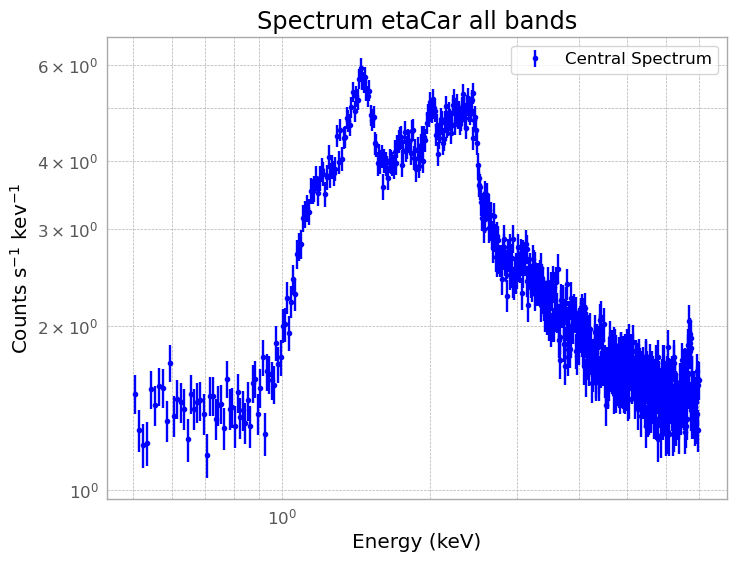

In [35]:
# Plot central spectrum
Plot.device = '/null'
AllData.clear()
AllModels.clear()

#Plot.device = "/xs"
Plot.xAxis="keV"

AllData.clear()
s1 = Spectrum(binspec)
s1.ignore("**-0.5")
s1.ignore("7.0-**")
Plot.xAxis="keV"
AllData.ignore("bad")
Plot("ldata")
Plot.device = '/null'
energies = Plot.x()      
counts = Plot.y()            
errors = Plot.yErr()       
plt.errorbar(energies, counts, yerr=errors, fmt='o', label="Central Spectrum", color='blue', markersize=3)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Energy (keV)")
plt.ylabel("Counts s$^{-1}$ kev$^{-1}$")
plt.title("Spectrum etaCar all bands")
plt.legend()
plt.grid(True, which="both", linestyle="--", lw=0.5)
plt.show()

### <span style="color:blue">$\textbf{Exercise (even harder)}$</span>:
#### For each of the three images, use the Chandra dmcopy tool and an appropriately defined region filter to produce an image file of the humunculus nebula that does not include the central point source and an image file that only includes the point source. Prepare SIMPUT files that model the nebula with a different spectral shape than the point source, merge them with simputmerge, and run the simulation again, now having a very realistic model for the whole source.